In [2]:
from itertools import combinations
from operator import itemgetter
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# Preprocessing

In [3]:
customer_df = pd.read_csv('customerdata.csv',low_memory=False)
customer_df.head()

,name,DELIVERY_DATE,CUSTOMER_ID,id,TIME_CREATED,product_item_id,PRODUCT_NAME,CATEGORY,QUANTITY,DELIVERY_QUANTITY,status,COMPLAINT_REASON,UNIT_MEASURE,code,PACKAGING,MRP,UNIT_PRICE,DISCOUNT
0,Bangalore,2021-03-07T00:00:00.000+05:30,24,23181828,2021-03-06T07:15:05.000+05:30,41534,Nandini Shubham-500ML Pouch,Milk,1,1,DELIVERED,NaN,500.0,ML,Pouch,22.0,22.0,0.0
1,Bangalore,2021-03-07T00:00:00.000+05:30,24,23181828,2021-03-06T07:15:05.000+05:30,41540,Nandini Toned Milk-500ML Pouch,Milk,1,1,DELIVERED,NaN,500.0,ML,Pouch,19.0,19.0,0.0
2,Bangalore,2021-03-07T00:00:00.000+05:30,33,23181829,2021-03-06T07:15:05.000+05:30,41569,Heritage Toned Milk-500ML Pouch,Milk,3,3,DELIVERED,NaN,500.0,ML,Pouch,21.0,21.0,0.0
3,Bangalore,2021-03-07T00:00:00.000+05:30,144,23181830,2021-03-06T07:15:05.000+05:30,41531,Heritage Full Cream Milk-500ML Pouch,Milk,2,2,DELIVERED,NaN,500.0,ML,Pouch,26.0,26.0,0.0
4,Bangalore,2021-03-07T00:00:00.000+05:30,144,23181830,2021-03-06T07:15:05.000+05:30,41536,Nandini Samrudhi-500ML Pouch,Milk,1,1,DELIVERED,NaN,500.0,ML,Pouch,23.0,23.0,0.0


In [4]:
items_df = customer_df[["product_item_id", "PRODUCT_NAME", "CATEGORY"]]
items_df = items_df.drop_duplicates()
items_df = items_df.reset_index(drop = True)
items_df = pd.DataFrame(items_df.groupby('product_item_id')["PRODUCT_NAME"].apply(list)).reset_index()
items_df

,product_item_id,PRODUCT_NAME
0,41527,[Heritage Standardised Milk-500ML Pouch]
1,41529,[Heritage Diet Fresh-500ML Pouch]
2,41531,[Heritage Full Cream Milk-500ML Pouch]
3,41532,[Nandini Double Toned Milk-500ML Pouch]
4,41534,[Nandini Shubham-500ML Pouch]
...,...,...
3268,90530,[Manchar Farms A2 Desi Cow Milk-500ML Pouch]
3269,90531,"[Grapes - Sharad Seedless-1KG, Grapes - Sharad..."
3270,90532,[Grapes - Sonaka Seedless-1KG Map]
3271,91122,[Bauli Moonfils Vanilla-45G Pouch]


In [6]:
purchase_df=customer_df.groupby(['CUSTOMER_ID','product_item_id']).size().reset_index(name='COUNT')
purchase_df['COUNT'] = 1
purchase_df

,CUSTOMER_ID,product_item_id,COUNT
0,24,41534,1
1,24,41540,1
2,24,41646,1
3,33,41569,1
4,144,41531,1
...,...,...,...
259006,539516,42360,1
259007,539516,42392,1
259008,539516,48726,1
259009,539516,79462,1


# Matrix Modeling

In [7]:
user_item_df = purchase_df.pivot(index='CUSTOMER_ID', columns='product_item_id', values='COUNT')
user_item_df

product_item_id,41527,41529,41531,41532,41534,41535,41536,41538,41540,41541,...,90521,90523,90525,90526,90528,90530,90531,90532,91122,91124
CUSTOMER_ID,,,,,,,,,,,,,,,,,,,,,
24,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
33,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
144,NaN,NaN,1.0,NaN,NaN,NaN,1.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
159,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
161,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
539498,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
539500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
539503,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
user_item_df.shape

(42315, 3273)

In [9]:
user_item_df.fillna(0).values.max()

1.0

In [10]:
norm_item_purchase = user_item_df.fillna(0)
trX = norm_item_purchase.values
trX[0:5]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

# Model

In [11]:
hiddenUnits = 20
visibleUnits =  len(user_item_df.columns)

vb = tf.Variable(tf.zeros([visibleUnits]), tf.float32) #Number of unique movies
hb = tf.Variable(tf.zeros([hiddenUnits]), tf.float32) #Number of features we're going to learn
W = tf.Variable(tf.zeros([visibleUnits, hiddenUnits]), tf.float32)

In [12]:
v0 = tf.zeros([visibleUnits], tf.float32)
#testing to see if the matrix product works
tf.matmul([v0], W)

<tf.Tensor: shape=(1, 20), dtype=float32, numpy=
array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.]], dtype=float32)>

In [13]:
#Phase 1: Input Processing
#defining a function to return only the generated hidden states 
def hidden_layer(v0_state, W, hb):
    h0_prob = tf.nn.sigmoid(tf.matmul([v0_state], W) + hb)  #probabilities of the hidden units
    h0_state = tf.nn.relu(tf.sign(h0_prob - tf.random.uniform(tf.shape(h0_prob)))) #sample_h_given_X
    return h0_state

#printing output of zeros input
h0 = hidden_layer(v0, W, hb)
print("first 15 hidden states: ", h0[0][0:15])

def reconstructed_output(h0_state, W, vb):
    v1_prob = tf.nn.sigmoid(tf.matmul(h0_state, tf.transpose(W)) + vb) 
    v1_state = tf.nn.relu(tf.sign(v1_prob - tf.random.uniform(tf.shape(v1_prob)))) #sample_v_given_h
    return v1_state[0]


v1 = reconstructed_output(h0, W, vb)
print("hidden state shape: ", h0.shape)
print("v0 state shape:  ", v0.shape)
print("v1 state shape:  ", v1.shape)

first 15 hidden states:  tf.Tensor([1. 1. 1. 1. 1. 1. 1. 0. 1. 0. 1. 1. 1. 1. 1.], shape=(15,), dtype=float32)
hidden state shape:  (1, 20)
v0 state shape:   (3273,)
v1 state shape:   (3273,)


In [14]:
def error(v0_state, v1_state):
    return tf.reduce_mean(tf.square(v0_state - v1_state))

err = tf.reduce_mean(tf.square(v0 - v1))
print("error" , err.numpy())

error 0.49159792


Epoch: 1 batch #: 0  of 84 sample #: 499 reconstruction error: 0.003666
Epoch: 1 batch #: 1  of 84 sample #: 499 reconstruction error: 0.001528
Epoch: 1 batch #: 2  of 84 sample #: 499 reconstruction error: 0.000917
Epoch: 1 batch #: 3  of 84 sample #: 499 reconstruction error: 0.000917
Epoch: 1 batch #: 4  of 84 sample #: 499 reconstruction error: 0.003361
Epoch: 1 batch #: 5  of 84 sample #: 499 reconstruction error: 0.011610
Epoch: 1 batch #: 6  of 84 sample #: 499 reconstruction error: 0.007027
Epoch: 1 batch #: 7  of 84 sample #: 499 reconstruction error: 0.000917
Epoch: 1 batch #: 8  of 84 sample #: 499 reconstruction error: 0.002750
Epoch: 1 batch #: 9  of 84 sample #: 499 reconstruction error: 0.001528
Epoch: 1 batch #: 10  of 84 sample #: 499 reconstruction error: 0.007638
Epoch: 1 batch #: 11  of 84 sample #: 499 reconstruction error: 0.019554
Epoch: 1 batch #: 12  of 84 sample #: 499 reconstruction error: 0.000611
Epoch: 1 batch #: 13  of 84 sample #: 499 reconstruction erro

Epoch: 2 batch #: 28  of 84 sample #: 499 reconstruction error: 0.000611
Epoch: 2 batch #: 29  of 84 sample #: 499 reconstruction error: 0.002750
Epoch: 2 batch #: 30  of 84 sample #: 499 reconstruction error: 0.003055
Epoch: 2 batch #: 31  of 84 sample #: 499 reconstruction error: 0.000917
Epoch: 2 batch #: 32  of 84 sample #: 499 reconstruction error: 0.003055
Epoch: 2 batch #: 33  of 84 sample #: 499 reconstruction error: 0.006111
Epoch: 2 batch #: 34  of 84 sample #: 499 reconstruction error: 0.025665
Epoch: 2 batch #: 35  of 84 sample #: 499 reconstruction error: 0.006111
Epoch: 2 batch #: 36  of 84 sample #: 499 reconstruction error: 0.002139
Epoch: 2 batch #: 37  of 84 sample #: 499 reconstruction error: 0.001222
Epoch: 2 batch #: 38  of 84 sample #: 499 reconstruction error: 0.000917
Epoch: 2 batch #: 39  of 84 sample #: 499 reconstruction error: 0.000611
Epoch: 2 batch #: 40  of 84 sample #: 499 reconstruction error: 0.000611
Epoch: 2 batch #: 41  of 84 sample #: 499 reconstru

Epoch: 3 batch #: 56  of 84 sample #: 499 reconstruction error: 0.000611
Epoch: 3 batch #: 57  of 84 sample #: 499 reconstruction error: 0.001528
Epoch: 3 batch #: 58  of 84 sample #: 499 reconstruction error: 0.000306
Epoch: 3 batch #: 59  of 84 sample #: 499 reconstruction error: 0.002139
Epoch: 3 batch #: 60  of 84 sample #: 499 reconstruction error: 0.001833
Epoch: 3 batch #: 61  of 84 sample #: 499 reconstruction error: 0.001222
Epoch: 3 batch #: 62  of 84 sample #: 499 reconstruction error: 0.000000
Epoch: 3 batch #: 63  of 84 sample #: 499 reconstruction error: 0.002750
Epoch: 3 batch #: 64  of 84 sample #: 499 reconstruction error: 0.010694
Epoch: 3 batch #: 65  of 84 sample #: 499 reconstruction error: 0.006111
Epoch: 3 batch #: 66  of 84 sample #: 499 reconstruction error: 0.000306
Epoch: 3 batch #: 67  of 84 sample #: 499 reconstruction error: 0.003972
Epoch: 3 batch #: 68  of 84 sample #: 499 reconstruction error: 0.000917
Epoch: 3 batch #: 69  of 84 sample #: 499 reconstru

Epoch: 4 batch #: 84  of 84 sample #: 314 reconstruction error: 0.007027
Epoch: 5 batch #: 0  of 84 sample #: 499 reconstruction error: 0.000611
Epoch: 5 batch #: 1  of 84 sample #: 499 reconstruction error: 0.000000
Epoch: 5 batch #: 2  of 84 sample #: 499 reconstruction error: 0.000306
Epoch: 5 batch #: 3  of 84 sample #: 499 reconstruction error: 0.000306
Epoch: 5 batch #: 4  of 84 sample #: 499 reconstruction error: 0.003666
Epoch: 5 batch #: 5  of 84 sample #: 499 reconstruction error: 0.014360
Epoch: 5 batch #: 6  of 84 sample #: 499 reconstruction error: 0.006722
Epoch: 5 batch #: 7  of 84 sample #: 499 reconstruction error: 0.000306
Epoch: 5 batch #: 8  of 84 sample #: 499 reconstruction error: 0.004888
Epoch: 5 batch #: 9  of 84 sample #: 499 reconstruction error: 0.000611
Epoch: 5 batch #: 10  of 84 sample #: 499 reconstruction error: 0.007027
Epoch: 5 batch #: 11  of 84 sample #: 499 reconstruction error: 0.016804
Epoch: 5 batch #: 12  of 84 sample #: 499 reconstruction erro

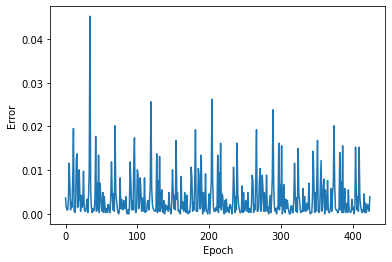

In [15]:
epochs = 5 #change to 5
batchsize = 500 #change to 500
errors = []
weights = []
K=1
alpha = 0.1

#creating datasets
train_ds = \
    tf.data.Dataset.from_tensor_slices((np.float32(trX))).batch(batchsize)



#for i in range(epochs):
#    for start, end in zip( range(0, len(trX), batchsize), range(batchsize, len(trX), batchsize)):
#        batch = trX[start:end]
#        cur_w = sess.run(update_w, feed_dict={v0: batch, W: prv_w, vb: prv_vb, hb: prv_hb})
#        cur_vb = sess.run(update_vb, feed_dict={v0: batch, W: prv_w, vb: prv_vb, hb: prv_hb})
#        cur_nb = sess.run(update_hb, feed_dict={v0: batch, W: prv_w, vb: prv_vb, hb: prv_hb})
#        prv_w = cur_w
#        prv_vb = cur_vb
#        prv_hb = cur_hb
#    errors.append(sess.run(err_sum, feed_dict={v0: trX, W: cur_w, vb: cur_vb, hb: cur_hb}))
#    print (errors[-1])
v0_state=v0
for epoch in range(epochs):
    batch_number = 0
    for batch_x in train_ds:

        for i_sample in range(len(batch_x)):           
            for k in range(K):
                v0_state = batch_x[i_sample]
                h0_state = hidden_layer(v0_state, W, hb)
                v1_state = reconstructed_output(h0_state, W, vb)
                h1_state = hidden_layer(v1_state, W, hb)

                delta_W = tf.matmul(tf.transpose([v0_state]), h0_state) - tf.matmul(tf.transpose([v1_state]), h1_state)
                W = W + alpha * delta_W

                vb = vb + alpha * tf.reduce_mean(v0_state - v1_state, 0)
                hb = hb + alpha * tf.reduce_mean(h0_state - h1_state, 0) 

                v0_state = v1_state

            if i_sample == len(batch_x)-1:
                err = error(batch_x[i_sample], v1_state)
                errors.append(err)
                weights.append(W)
                print ( 'Epoch: %d' % (epoch + 1), 
                       "batch #: %i " % batch_number, "of %i" % (len(trX)/batchsize), 
                       "sample #: %i" % i_sample,
                       'reconstruction error: %f' % err)
        batch_number += 1




plt.plot(errors)
plt.ylabel('Error')
plt.xlabel('Epoch')
plt.show()

# Recommendation

In [28]:
mock_user_id = 33

In [29]:
# customer_df[(CUSTOMER_ID[mock_user_id]]
# customer_df.loc[mock_user_id]
customer_df.loc[customer_df['CUSTOMER_ID'] == mock_user_id].groupby(['CUSTOMER_ID','PRODUCT_NAME']).size().reset_index(name='COUNT')

,CUSTOMER_ID,PRODUCT_NAME,COUNT
0,33,Heritage Toned Milk-500ML Pouch,14


In [30]:
#Selecting the input user
inputUser = trX[mock_user_id-1].reshape(1, -1)

inputUser = tf.convert_to_tensor(trX[mock_user_id-1],"float32")
v0 = inputUser

print(v0)
v0.shape

tf.Tensor([0. 0. 0. ... 0. 0. 0.], shape=(3273,), dtype=float32)


TensorShape([3273])

In [31]:
v0test = tf.zeros([visibleUnits], tf.float32)
v0test.shape

TensorShape([3273])

In [32]:
#Feeding in the user and reconstructing the input

hh0 = tf.nn.sigmoid(tf.matmul([v0], W) + hb)

vv1 = tf.nn.sigmoid(tf.matmul(hh0, tf.transpose(W)) + vb)

rec = vv1

tf.maximum(rec,1)
for i in vv1:
    print(i)

tf.Tensor(
[3.2588218e-03 1.5637947e-03 5.7151509e-03 ... 7.2075522e-06 3.3310207e-06
 6.0809734e-06], shape=(3273,), dtype=float32)


In [33]:
scored_items_df_mock = items_df[items_df['product_item_id'].isin(user_item_df.columns)]
scored_items_df_mock = scored_items_df_mock.assign(RecommendationScore = rec[0])
scored_items_df_mock.sort_values(["RecommendationScore"], ascending=False).head(20)

,product_item_id,PRODUCT_NAME,RecommendationScore
7,41538,[Nandini Cow Milk-500ML Pouch],0.221916
1776,79903,[Nandini Santhrupthi-500ML Pouch],0.084386
407,56871,[Erden Creamery Farm Fresh Buffalo Milk-500ML ...,0.043916
15,41610,[Nandini Curd-500ML Pouch],0.037795
213,48685,[Nandini Special Toned Milk-500ML Pouch],0.021761
2052,81250,[Sunpure Sunflower Oil-1L Pouch],0.020789
3,41532,[Nandini Double Toned Milk-500ML Pouch],0.015092
156,43190,[Akshayakalpa A2 Farm Fresh Organic Milk-500ml...,0.013218
8,41540,[Nandini Toned Milk-500ML Pouch],0.012979
297,49373,[Farm Connect Organic Farm Fresh Cow Milk-500M...,0.009171


In [34]:
items_df_mock = purchase_df[purchase_df['CUSTOMER_ID'] == mock_user_id]
items_df_mock.head()

,CUSTOMER_ID,product_item_id,COUNT
3,33,41569,1


In [35]:
#Merging movies_df with ratings_df by MovieID
merged_df_mock = scored_items_df_mock.merge(items_df_mock, on='product_item_id', how='outer').drop(columns=['CUSTOMER_ID', 'COUNT'])

In [36]:
merged_df_mock.sort_values(["RecommendationScore"], ascending=False).head(20)

,product_item_id,PRODUCT_NAME,RecommendationScore
7,41538,[Nandini Cow Milk-500ML Pouch],0.221916
1776,79903,[Nandini Santhrupthi-500ML Pouch],0.084386
407,56871,[Erden Creamery Farm Fresh Buffalo Milk-500ML ...,0.043916
15,41610,[Nandini Curd-500ML Pouch],0.037795
213,48685,[Nandini Special Toned Milk-500ML Pouch],0.021761
2052,81250,[Sunpure Sunflower Oil-1L Pouch],0.020789
3,41532,[Nandini Double Toned Milk-500ML Pouch],0.015092
156,43190,[Akshayakalpa A2 Farm Fresh Organic Milk-500ml...,0.013218
8,41540,[Nandini Toned Milk-500ML Pouch],0.012979
297,49373,[Farm Connect Organic Farm Fresh Cow Milk-500M...,0.009171
